# BAG3 Co-IP Watson Analysis
##### by Emir Turkes

This analysis utilizes Watson for Drug Discovery to validate Co-IP MS (co-immunoprecipitation mass spectrometry) data with BAG3 as the primary target. There are 4 goals thus far:
1. Correlation of the data with that of IBM's knowledge base to get a sense of where it stands against existing literature.
2. Clustering of the Co-IP'ed proteins into various ontological groups (disease relevance, biochemical pathways, and chemical classification come to mind)
3. Breakdown of upstream, downstream, and intermediate biochemical pathways between Co-IP'ed proteins and their clusters.
4. Confirmation of enrichment of proteins involved in endocytosis/membrane fusion event and dendritic localization/function

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

# Copyright 2019 Emir Turkes
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""The main analysis routine."""


import os
import types

import numpy as np
import pandas as pd

import ibm_botocore.client as ic
import ibm_boto3 as ib
import pixiedust

In [10]:
# The code was removed by Watson Studio for sharing.

### Cleaning of Co-IP MS data

We do some basic data manipulations to get an ordered list of 20 genes by their coupling with BAG3, excluding BAG3 itself.  

**Note:**  
The data originally contained #DIV/0! errors, as there were many cells in the shBAG3 column that contained null values. Assuming these null values were to reflect values less than 1, they were arbitrarily reassigned a value of 0.5 (the median of 0 and 1).

In [11]:
# Read in data.
# The correction of null values was done outside of this notebook.
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='co_ip_no_keratin.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
co_ip_df = pd.read_csv(body)

# Sort by "fold of changes".
cols = ["fold of changes"]
co_ip_df.drop(0, inplace=True)
co_ip_df[cols] = co_ip_df[cols].astype('int')

# Reduce to two columns and top 21 genes, in order to exclude BAG3 itself.
cols = ["Unnamed: 1", "fold of changes"]
co_ip_df = co_ip_df[cols]
co_ip_df.rename(columns={"Unnamed: 1": "Genes", "fold of changes": "Fold change"}, inplace=True)
co_ip_df = co_ip_df.head(21)

# Cut string to only gene name, capitalize, and remove BAG3.
cols = "Genes"
co_ip_df[cols] = co_ip_df[cols].str.extract("((?<=GN=).*(?= PE=))", expand=True)
co_ip_df["Genes"] = co_ip_df["Genes"].str.upper()
co_ip_df = co_ip_df[~co_ip_df.Genes.str.contains("BAG3")]
co_ip_df = co_ip_df.reset_index(drop=True)
co_ip_df.index = co_ip_df.index + 1

# Replace gene names with Watson entities.
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='EntitySet_BAG3-co-ip-20-no-BAG3_2019-02-27_09-47-55.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
entity_set_df = pd.read_csv(body)
entity_set_df.index = entity_set_df.index + 1
co_ip_df["Genes"] = entity_set_df["Entity name"]

co_ip_df

,Genes,Fold change
1,PLEC,44
2,ANK2,44
3,BAG5,34
4,SPTBN2,30
5,HSPA8,21
6,NES,20
7,MYH10,20
8,CAMK2A,20
9,NEFM,20
10,SRCIN1,19


## Watson Explore Networks

First, we visualize the relationship between the top 20 genes based on literature reporting of their modulation of BAG3. Though Watson Explore Networks is set to the lowest thresholds (described below), relationships with only two other genes were reported:  
**HSPA8**  
**CAPZB**  

Note the direction of the arrows, which indicate the direction of each modulation.

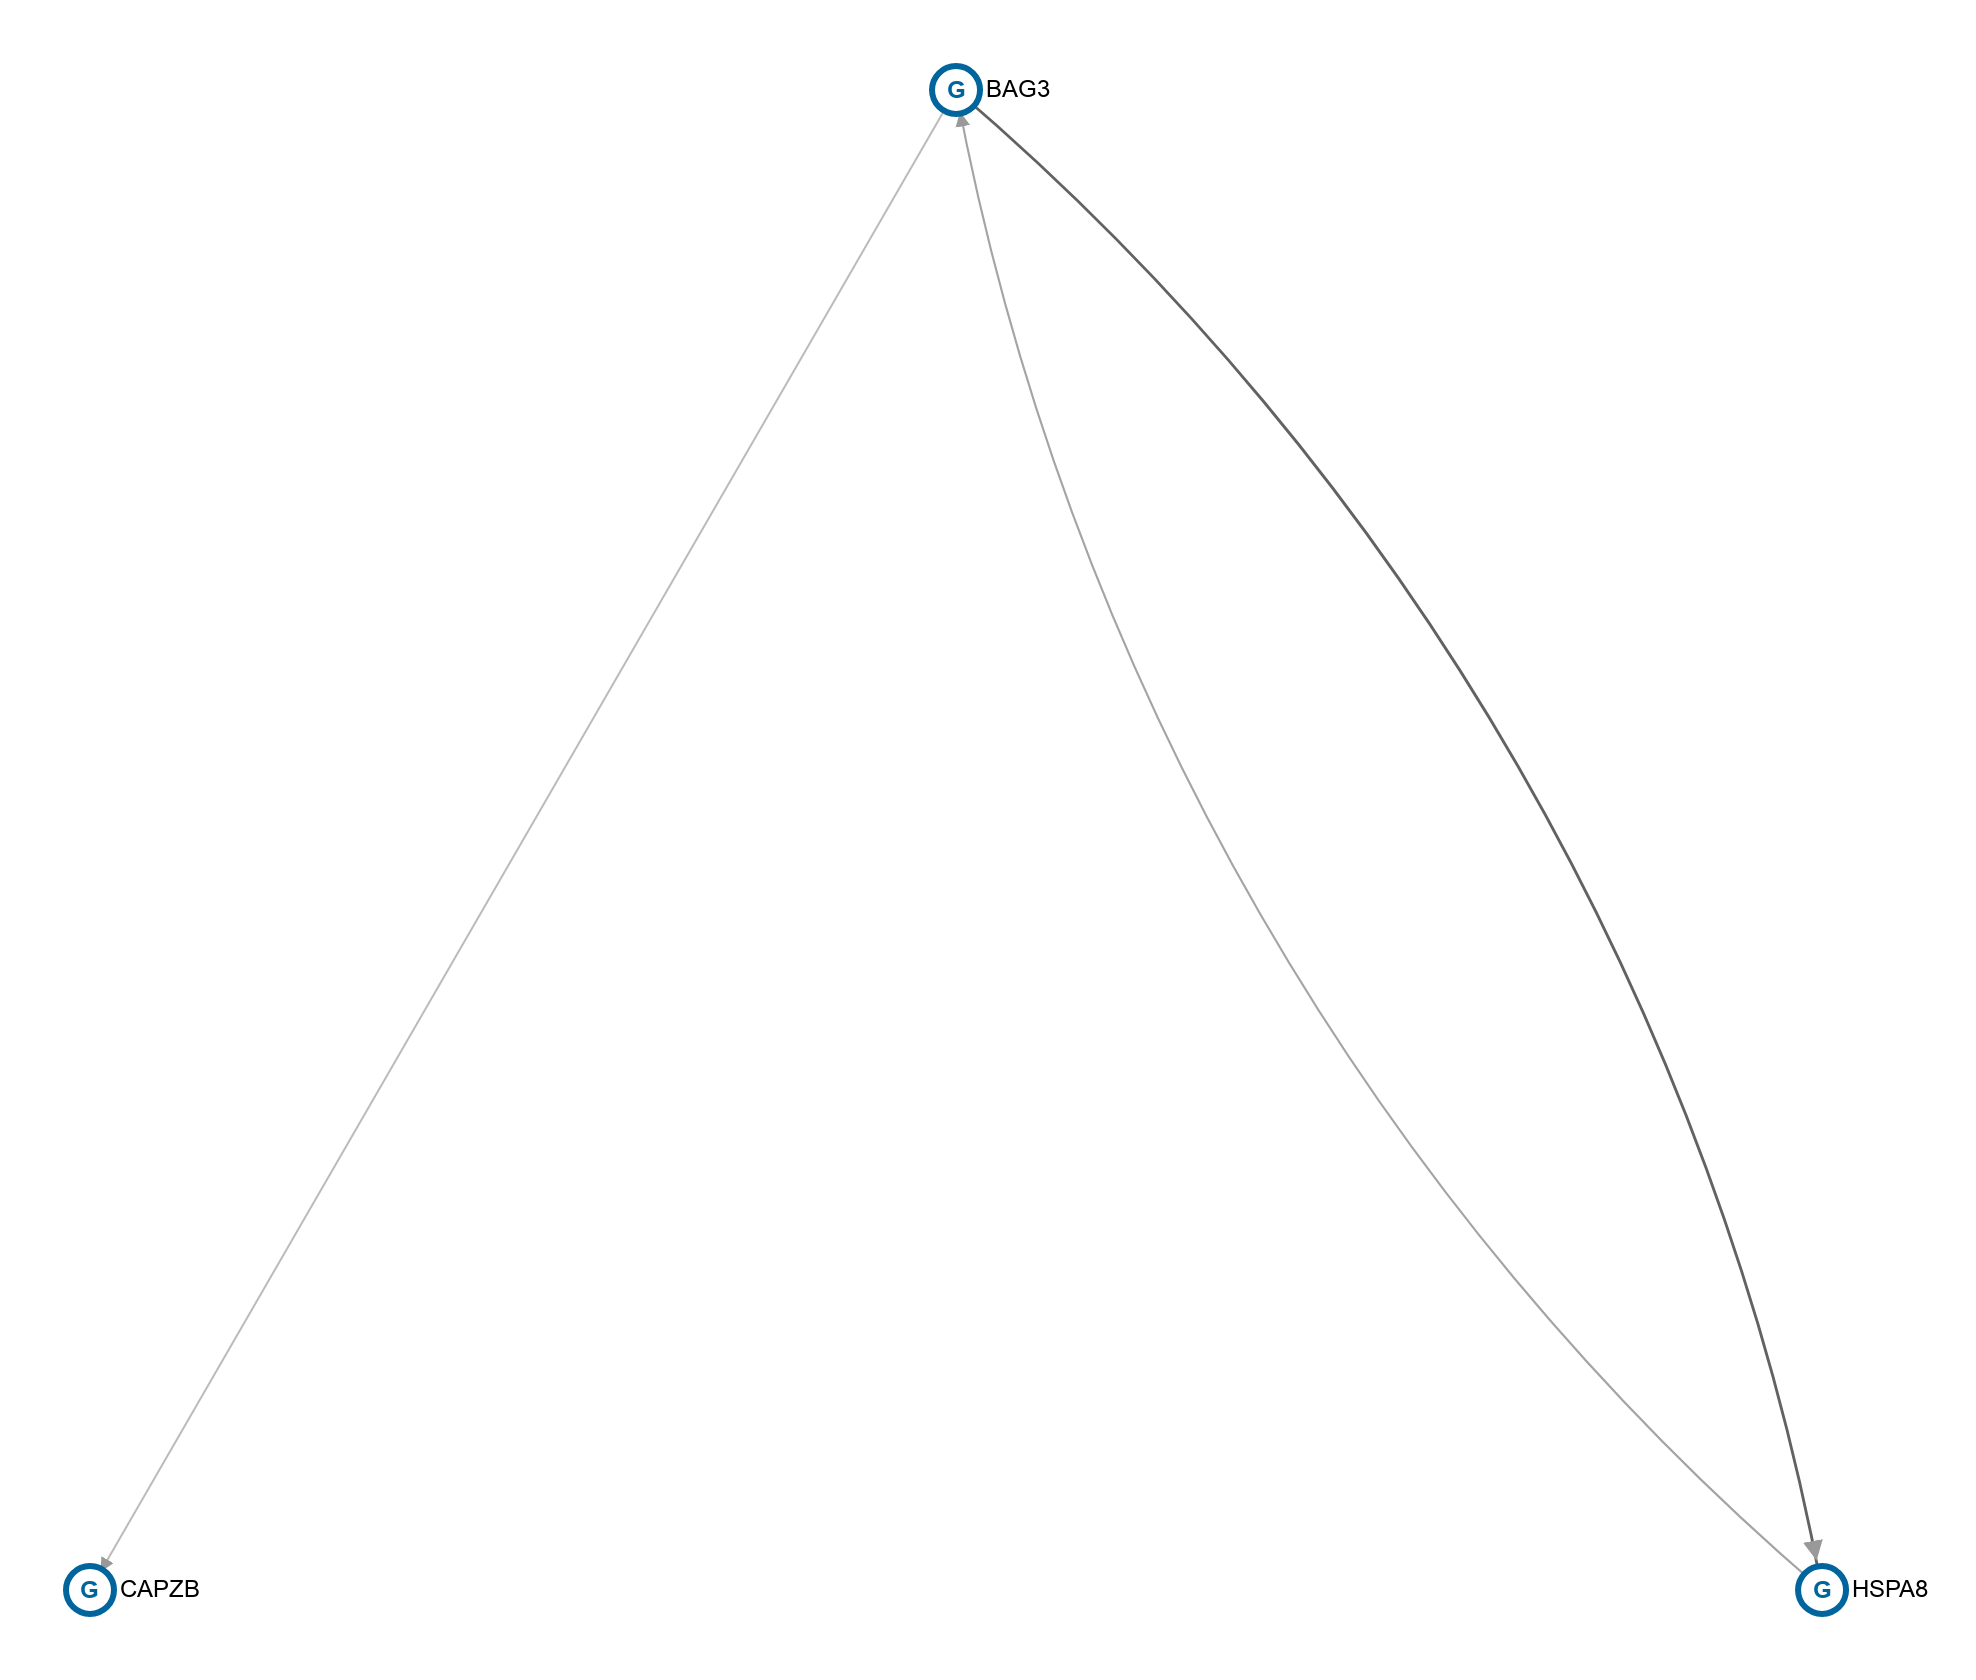

### Report confidence scores and number of documents

Watson Explore Networks uses confidence scores that assess the likelihood of a relationship as happening above chance through a scale ranging from 0-100. In addition, information is also provided on the number of documents retrieved and associated metadata of these documents.  

The following minimum thresholds were set:
```python
confidence_score >= 1
num_documents >= 1
```

Below is a summary of the most relevant information.

In [12]:
# Read in data.
body = client_75340283764447f99797650de21e6211.get_object(Bucket='bag3coip-donotdelete-pr-wlavvdgoryxgjb',Key='relationshipgraph14809_2019-02-27_09-54-25.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
relationship_graph_df = pd.read_csv(body)

# Sort by "Confidence".
cols = ["Confidence"]
relationship_graph_df[cols] = relationship_graph_df[cols].astype('int')
relationship_graph_df.sort_values(by=cols, inplace=True, ascending=False)

# Reduce to three columns.
cols = ["Source name", "Target name", "Confidence", "Documents"]
relationship_graph_df = relationship_graph_df[cols]

display(relationship_graph_df)

Source name,Target name,Confidence,Documents
BAG3,HSPA8,81,24
HSPA8,BAG3,72,4
BAG3,CAPZB,57,1


### Merge confidence scores with the Co-IP gene list

It appears that BAG3 -> HSPA8 is the most strongly supported relationship in the literature. Let's merge the above table with the Co-IP list to get a clearer picture.

In [ ]:
merge_df = co_ip_df

# Hard coded at the moment.
merge_df.at[5, "Confidence"] = 88
merge_df.at[18, "Confidence"] = 57
#merge_df.at[]

display(merge_df)

Genes,Fold change,Confidence
PLEC,44,nan
ANK2,44,nan
BAG5,34,nan
SPTBN2,30,nan
HSPA8,21,88.0
NES,20,nan
MYH10,20,nan
CAMK2A,20,nan
NEFM,20,nan
SRCIN1,19,nan


## Work in progress - more coming soon